# Introduction à JAX avec une petite application

## 1. Présentation de JAX

[JAX](https://github.com/google/jax) est un projet récent développé par des ingénieurs de Google pour avoir une API compatible avec des outils existant (Numpy...) capable d'utiliser des CPU, TPU, GPU sans avoir à changer le code.

JAX contient les éléments suivant :
- *jax.numpy* une couche de compatibilité avec Numpy.
- *jit* un compilateur Just In Time (JIT) pour Python.
- *grad* pour faire du calcul automatique de dérivées (remplace et améliore *autograd*).
- *vmap* pour faire de l'auto-vectorisation.


## 2. Interfaçage avec Numpy

### 2.1. Une introduction

Commençons par faire les importations suivantes,

In [14]:
import numpy as np
import jax
import jax.numpy as jnp  # Couche de compatibilité avec Numpy

*jax.numpy* propose des fonctions très similaires à celles de Numpy. Par exemple nous pouvons construire les tableaux de façon classique. 

In [15]:
tab = jnp.zeros((10, 10))  # Une matrice de taille 10x10

In [16]:
tab

Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Attention les tableaux JAX ne sont pas mutables.

In [17]:
# tab[1] = 0

Pour des raisons d'efficacités, toute modification induit un nouveau tableau.

Les calculs se font comme pour Numpy.

In [18]:
(tab + 1) * 2.0 - jnp.diag(jnp.ones((10, )))

Array([[1., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 1., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 1., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 1., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 1., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 1., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 1., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 1., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 1., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 1.]], dtype=float32)

### 2.2. Mélange avec Numpy

Il est possible de mélanger des éléments Numpy avec des élements JAX. Par contre attention au type du résultat final.

In [19]:
res = (tab + 1) * 2.0 - np.diag(np.ones((10, )))

In [20]:
type(res)

jaxlib.xla_extension.ArrayImpl

Le résultat sera toujours un tableau JAX.

## 3. Préparation d'un jeu de données

Nous allons commencer par générer un jeu de données simple pour tester les différents algorithmes et méthodes.

Pour cela, nous allons utiliser la fonction [make_blobs](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) proposée par Scikit-Learn.

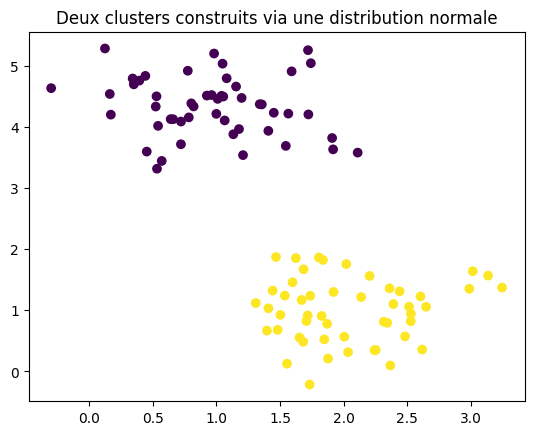

In [21]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=2, cluster_std=0.5, random_state=0)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Deux clusters construits via une distribution normale")
plt.show()

In [22]:
X, y

(array([[ 3.1368855 ,  1.56592763],
        [ 1.4815332 ,  0.67875364],
        [ 0.3498724 ,  4.69253251],
        [ 0.5323772 ,  3.31338909],
        [ 2.64928242,  1.05613497],
        [ 1.2091013 ,  3.53566548],
        [ 0.99914934,  4.2101954 ],
        [ 3.01673853,  1.63792106],
        [ 0.78260667,  4.15263595],
        [ 1.65356269,  0.55288877],
        [ 0.802314  ,  4.38196181],
        [ 1.8706766 ,  0.77797407],
        [ 1.08040757,  4.79210685],
        [ 0.5226209 ,  4.32976003],
        [ 1.92126584,  1.29889186],
        [ 3.24683991,  1.3699034 ],
        [ 2.61858548,  0.35769791],
        [ 0.64003985,  4.12401075],
        [ 1.39731382,  0.66687136],
        [ 1.67030948,  1.16728826],
        [ 1.05374379,  4.49286859],
        [ 0.82049381,  4.33187   ],
        [ 1.68548602,  1.66917096],
        [ 0.39369516,  4.75420057],
        [ 2.31690585,  0.81189049],
        [ 0.92466065,  4.50908658],
        [ 1.68289011,  0.48444439],
        [ 0.98152009,  5.196

Pour des raisons de tests, il est toujours bon de découper cet ensemble en deux avec `make_test_split`.

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


## 4. Construction d'un petit perceptron à une couche

Pour faire des comparaisons de temps de calculs et d'écriture de code, nous allons commencer par coder un perceptron à une couche avec une sortie linéaire (pour commencer simplement).

Pour rappel, la fonction de décision est la suivante,

$$ h(x) = \sigma(w^t x + b) $$

avec $w \in \mathbb{R}^d$ un vecteur à inférer, $b \in \mathbb{R}$ un offset et $\sigma$ la fonction de sortie.


### 4.1. Commençons avec Numpy

Écrivons la fonction et son gradient pour faire une simple descente de gradient.

In [24]:
def perceptron(x, w, b):
    res = w.T @ x + b
    return res

In [25]:
def gradient(x, w, b):
    return w

Maintenant construisons une descente de gradient pour inférer $w$ avec une fonction de perte type $\ell_2$. On cherche donc à résoudre le problème suivant,

$$(P)\qquad \min_{w,b} \sum_i \tfrac{1}{2} \|h(x_i) - y_i\|^2 $$

In [26]:
def compute_loss(X, y, w, b):
    """Fonction de perte L2."""
    predictions = X @ w + b
    errors = predictions - y
    loss = 0.5 * np.sum(errors ** 2)
    return loss

def compute_gradients(X, y, w, b):
    """Calcul des gradients de la perte par rapport à w et b."""
    predictions = X @ w + b
    errors = predictions - y
    grad_w = X.T @ errors
    grad_b = np.sum(errors)
    return grad_w, grad_b

def gradient_descent(X, y, w_init, b_init, learning_rate, num_iterations):
    """Descente de gradient pour minimiser la perte L2."""
    w = w_init
    b = b_init
    for i in range(num_iterations):
        grad_w, grad_b = compute_gradients(X, y, w, b)
        
        # Mise à jour des paramètres
        w -= learning_rate * grad_w
        b -= learning_rate * grad_b

        # Affichage de la perte toutes les 100 itérations
        if i % 100 == 0:
            loss = compute_loss(X, y, w, b)
            print(f"Iteration {i}: Loss = {loss}")

    return w, b

Testons le code.

In [ ]:
w_init = np.zeros(2,)
b_init = 1.0
learning_rate = 0.01
num_iterations = 1000

# Optimisation
w_opt, b_opt = gradient_descent(X, y, w_init, b_init, learning_rate, num_iterations)



Iteration 0: Loss = 2561.067211220639
Iteration 100: Loss = 1.3670401454368272e+212
Iteration 200: Loss = inf
Iteration 300: Loss = nan
Iteration 400: Loss = nan
Iteration 500: Loss = nan
Iteration 600: Loss = nan
Iteration 700: Loss = nan
Iteration 800: Loss = nan
Iteration 900: Loss = nan


C:\Users\bausm\AppData\Local\Temp\ipykernel_22744\1544910749.py:5: RuntimeWarning: overflow encountered in square
  loss = 0.5 * np.sum(errors ** 2)
C:\Users\bausm\AppData\Local\Temp\ipykernel_22744\1544910749.py:12: RuntimeWarning: overflow encountered in matmul
  grad_w = X.T @ errors
c:\Users\bausm\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\bausm\AppData\Local\Temp\ipykernel_22744\1544910749.py:10: RuntimeWarning: invalid value encountered in matmul
  predictions = X @ w + b


### 4.2 Utilisation du calcul automatique du gradient

Maintenant nous allons passer par la fonction `grad` pour calculer automatiquement le gradient

In [31]:
def loss_function(w, b, X, y):
    """Fonction de perte L2."""
    predictions = jnp.dot(X, w) + b
    errors = predictions - y
    loss = 0.5 * jnp.sum(errors ** 2)
    return loss

# Gradient automatique avec JAX
loss_grad = jax.grad(loss_function, argnums=(0, 1))

def gradient_descent(X, y, w_init, b_init, learning_rate, num_iterations):
    """Descente de gradient avec JAX."""
    w, b = w_init, b_init

    for i in range(num_iterations):
        grad_w, grad_b = loss_grad(w, b, X, y)

        # Mise à jour des paramètres
        w -= learning_rate * grad_w
        b -= learning_rate * grad_b

        # Affichage de la perte toutes les 100 itérations
        if i % 100 == 0:
            loss = loss_function(w, b, X, y)
            print(f"Iteration {i}: Loss = {loss}")

    return w, b


w_init = np.zeros(2,)
b_init = 1.0
learning_rate = 0.01
num_iterations = 1000

# Optimisation
w_opt, b_opt = gradient_descent(X, y, w_init, b_init, learning_rate, num_iterations)

Iteration 0: Loss = 2561.0673828125
Iteration 100: Loss = nan
Iteration 200: Loss = nan
Iteration 300: Loss = nan
Iteration 400: Loss = nan
Iteration 500: Loss = nan
Iteration 600: Loss = nan
Iteration 700: Loss = nan
Iteration 800: Loss = nan
Iteration 900: Loss = nan


Comparer les temps de calculs.

In [ ]:
# A faire

Nous pouvons en profiter pour prendre la sigmoid pour $\sigma$.

In [ ]:
def perceptron_sigmoid(x, w, b):
    res = w.T @ x + b
    # A compléter
    return res

Refaire les calculs précédent.

In [ ]:
# A faire

### 4.3 Accélération avec JIT

Maintenant nous pouvons tester le JIT en améliorant le perceptron. Que constatons-nous au niveau du temps de calculs ?

**Remarque :** il peut être nécessaire d'augmenter la taille du jeu de données pour voir une vraie différence !

In [ ]:
# A faire

## 5. Perceptron à deux couches

Maintenant que nous avons un cadre pour calculer facilement des gradients avec des accélérateurs. Nous pouvons augmenter la complexité du modèle et ajouter une couche.

Pour rappel, la fonction de décision devient alors la suivante,

$$ h(x) = \sigma_1(w_1^t \sigma_2 (w_2^t x + b_2) + b_1) $$

### 5.1 Optimisation manuelle

Commençons par écrire la nouvelle fonction objectif.

In [ ]:
# A faire

Optimisons avec la boucle précédente

In [ ]:
# A faire

### 5.2 Optimisation via Optax

Optax propose un ensemble de méthode d'optimisation. Essayons de résoudre le problème précédent avec une descente de gradient stochastique (SGD).

In [ ]:
# A faire

## 6. Flax (pour les plus rapides)

Flax propose un cadre pour construire des réseaux de neurones. Utiliser ce cadre pour refaire le perceptron à deux couches et son apprentissage.

In [ ]:
# Bonne chance